In [1]:
# add additional processes to serve as workers 
n_procs = 3
addprocs(n_procs);  

In [2]:
# add present working directory to path from which to load modules
push!(LOAD_PATH, ".") 

# load module DynamicProgramming on each of the processes 
using DynamicProgramming
using Interpolations
for p in workers()
    remotecall_fetch(p, eval, :(using DynamicProgramming))
    remotecall_fetch(p, eval, :(using Interpolations))
end

In [3]:
## define the dynamic programming problem 

# dynamics 
@everywhere function f(t::Int64, x::Array{Float64, 1}, u::Array{Float64, 1}, theta::Array{Float64, 1}) 
    xu = x[1]*(1-u[1])
    # sensitivity w.r.t. r 
    Df_r = xu*(1 - x[1]*(1-u[1]))
    Df_xt = (1+theta[1])*(1 - u[1]) - 2*theta[1]*(1 - u[1])^2*x[1]  
    return [xu + theta[1]*xu*(1 - xu); Df_r + Df_xt*x[2]]
end

# nominal parameter value 
@everywhere theta0 = [0.5, 1000.0]
f(0, [1.; 0.], [0.3], theta0)

# time horizon 
@everywhere N = 25

# state dimension 
@everywhere n = 2

# stage reward function 
@everywhere function phi(x::Array{Float64, 1}, u::Array{Float64, 1}, theta::Array{Float64, 1})
    if x[1] == 0 
        return 0
    else
        return  x[1]*(1 - u[1]) + (theta[2]/x[1])^2*(1 - u[1])*x[2]^2 
    end
end

# define state grid 
@everywhere nx1 = 50 # number of grid points in each dimension  
@everywhere nx2 = 50
@everywhere xgrid = (linspace(0, 1, nx1), linspace(-1, 1, nx2)) 

# define input grid 
nu1 = 100
@everywhere ugrid = (linspace(0, 1, nx1),)
length(ugrid)

1

In [4]:
# compute value function
@time J = dp_loop(f, phi, ugrid, xgrid, theta0, N); 

====== Constructing array J ======
J is size (50,50) by 25
====== Array J constructed  ======
Step k = 24
Step k = 23
Step k = 22
Step k = 21
Step k = 20
Step k = 19
Step k = 18
Step k = 17
Step k = 16
Step k = 15
Step k = 14
Step k = 13
Step k = 12
Step k = 11
Step k = 10
Step k = 9
Step k = 8
Step k = 7
Step k = 6
Step k = 5
Step k = 4
Step k = 3
Step k = 2
Step k = 1
  4.516349 seconds (1.80 M allocations: 88.602 MB, 0.47% gc time)


In [5]:
# compute optimal trajectory from initial condition x0 
x0 = [1.; 0.]
x_opt, u_opt = dp_rollout(J, x0, f, phi, ugrid, xgrid, theta0, N);

In [6]:
using Gadfly
using Colors

berkeley_blue = RGB((1/256*[ 45.,  99., 127.])...)
berkeley_gold = RGB((1/256*[224., 158.,  25.])...); 

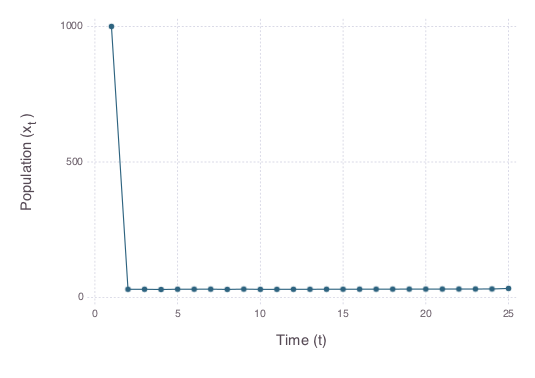

In [7]:
# plot optimal state trajectory 
p = plot(x=1:N, y=theta0[2]*x_opt[1, :], 
            Guide.XLabel("Time (t)"), 
            Guide.YLabel("Population (x<sub>t</sub> )"), 
            Geom.line, Geom.point,
            Theme(default_color=berkeley_blue)
)
draw(PDF("flies_optimal_input.pdf", 15cm, 10cm), p)
p

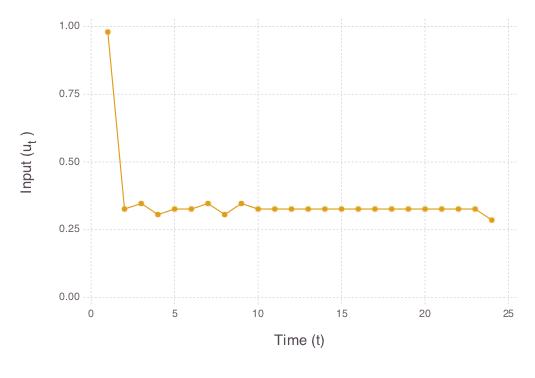

In [8]:
# plot optimal input sequence 
p = plot(x=1:N-1, y=u_opt, 
        Guide.XLabel("Time (t)"), 
        Guide.YLabel("Input (u<sub>t</sub> )"), 
        Geom.line, Geom.point,
        Theme(default_color=berkeley_gold)
)
draw(PDF("flies_optimal_states.pdf", 15cm, 10cm), p)
p